## Optimal statistic with discovery

In [1]:
import sys
import os
import glob

import tqdm

In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [3]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [4]:
import discovery as ds

Read nanograv pulsars

In [5]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

Run with fewer pulsars

In [6]:
psrs = allpsrs[:5]

Set up GlobalLikelihood object. The GP named 'gw' will be used to build the optimal statistic; everything else will be included in individual pulsar noise. This GW object should be identical for every pulsar, and have common parameters only.

In [7]:
Tspan = ds.getspan(psrs)
t0 = ds.getstart(psrs)

gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True, variable=True),
                                                ds.makegp_fftcov(psr, ds.powerlaw, 61, oversample=6, T=Tspan, name='red_noise'),
                                                ds.makegp_fftcov(psr, ds.brokenpowerlaw, 61, oversample=6, T=Tspan, t0=t0,
                                                                 common=['gw_log10_A', 'gw_gamma', 'gw_log10_fb'], name='gw')
                                                ]) for psr in psrs])

### Basic OS

Make OS object

In [8]:
%time os = ds.OS(gbl)

CPU times: user 42.4 ms, sys: 3.07 ms, total: 45.4 ms
Wall time: 46 ms


Get a random set of parameters, force gamma to 13/3

In [9]:
p0 = ds.sample_uniform(os.params, priordict={'gw_(.*_)?gamma': [13/3,13/3]})

Compute the OS for the data. You get also the corresponding sigma, SNR, and the amplitude of the GW.

In [10]:
os.os(p0)

{'os': Array(5.9697388e-28, dtype=float64),
 'os_sigma': Array(3.13921053e-27, dtype=float64),
 'snr': Array(0.19016688, dtype=float64),
 'log10_A': -13.037182460160352}

### Alternative ORFs

The ORF takes only one parameter (the product `z = dot(pos1, pos2)`). Discovery predefines `hd_orfa`, `monopole_orfa`, `dipole_orfa`.

In [63]:
os.os(p0, ds.monopole_orfa)

{'os': Array(5.50934365e-30, dtype=float64),
 'os_sigma': Array(1.03401729e-29, dtype=float64),
 'snr': Array(0.53280963, dtype=float64),
 'log10_A': -12.11677005017712}

In [64]:
os.os(p0, ds.dipole_orfa)

{'os': Array(7.35383537e-30, dtype=float64),
 'os_sigma': Array(1.75419332e-29, dtype=float64),
 'snr': Array(0.41921465, dtype=float64),
 'log10_A': -12.11677005017712}

### "Marginalized" OS 

Create a population of parameters (normally we'd get them from an MCMC run).

In [65]:
p0s = ds.sample_uniform(os.params, priordict={'gw_(.*_)?gamma': [13/3,13/3]}, n=5)

In [66]:
p0s['B1855+09_red_noise_gamma']

array([0.89509136, 4.93412033, 3.98655564, 1.34624826, 5.96623953])

Then we `jax.vmap` over parameter sets

In [67]:
os_vpar = jax.vmap(os.os)

In [68]:
os_vpar(p0s)

{'log10_A': array([-15.38365639, -14.23822937, -14.7741985 , -13.83253618,
        -12.85009408]),
 'os': Array([ 1.09293369e-29,  4.94251978e-30,  1.83796125e-30, -8.71881909e-30,
         2.06918798e-30], dtype=float64),
 'os_sigma': Array([8.25075514e-31, 5.87877944e-31, 4.84132509e-31, 2.30306809e-30,
        4.59172685e-30], dtype=float64),
 'snr': Array([13.24646861,  8.40739108,  3.79640122, -3.78574092,  0.45063394],      dtype=float64)}

### Scrambles

`os.scramble` takes as a second argument an array (or list) of pulsar positions of dimension `(npsr, 3)`

In [69]:
jnp.array(os.pos)

Array([[ 0.235276  , -0.95735312,  0.16769083],
       [ 0.38400231, -0.84770959,  0.36596539],
       [ 0.41542527, -0.76954724,  0.4849937 ],
       [ 0.98151466,  0.10005025,  0.16315308],
       [ 0.98761743,  0.1320268 ,  0.08473928],
       [ 0.42846049,  0.61411581,  0.66278457],
       [ 0.40865968,  0.75692046,  0.5099693 ],
       [ 0.23974131,  0.63501757, -0.73435467],
       [ 0.21645786,  0.96384399,  0.15540512],
       [ 0.01039278,  0.96199519,  0.27286854]], dtype=float64)

In [70]:
os.scramble(p0, jnp.array(os.pos))

{'os': Array(-3.83283248e-30, dtype=float64),
 'os_sigma': Array(4.35015195e-29, dtype=float64),
 'snr': Array(-0.08810801, dtype=float64),
 'log10_A': -12.11677005017712}

To build a background you'll want a random array of positions of dimension `(nscramble, npsr, 3)`

In [71]:
key = ds.matrix.jnpkey(42)
rpos = jax.random.normal(key, (15, len(psrs), 3))
npos = rpos / jnp.linalg.norm(rpos, axis=2)[:,:,None] # normalize vectors

Then we `jax.vmap` over positions (the second argument).

In [72]:
scramble_vpos = jax.vmap(os.scramble, (None,0))

In [73]:
scramble_vpos(p0, npos)

{'log10_A': Array([-12.11677005, -12.11677005, -12.11677005, -12.11677005,
        -12.11677005, -12.11677005, -12.11677005, -12.11677005,
        -12.11677005, -12.11677005, -12.11677005, -12.11677005,
        -12.11677005, -12.11677005, -12.11677005],      dtype=float64, weak_type=True),
 'os': Array([ 1.95249806e-29,  1.81802271e-29,  2.09065617e-30,  5.97532235e-30,
        -5.60806608e-29, -7.20305872e-30,  1.25598639e-29, -2.93565709e-29,
        -5.66463939e-30,  2.57360339e-29, -4.86104165e-29, -1.53192259e-29,
         9.88381790e-31, -1.09649446e-30, -7.70309569e-30], dtype=float64),
 'os_sigma': Array([8.33156373e-29, 1.08359434e-28, 3.68741026e-29, 6.98922008e-29,
        1.02361543e-28, 9.82447774e-29, 6.26563180e-29, 7.74374387e-29,
        5.41309179e-29, 5.00710894e-29, 8.15971780e-29, 8.88932359e-29,
        6.98856407e-29, 7.25703275e-29, 6.73513784e-29], dtype=float64),
 'snr': Array([ 0.23434953,  0.16777706,  0.05669714,  0.08549341, -0.54786846,
        -0.0733174

### Phase shifts

These require a diagonal Fourier GW object.

In [191]:
gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True),
                                                ds.makegp_fourier(psr, ds.brokenpowerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.brokenpowerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma', 'gw_log10_fb'], name='gw')
                                                ]) for psr in psrs])

In [192]:
os = ds.OS(gbl)

In [193]:
os.os(p0)

{'os': Array(-4.30823733e-27, dtype=float64),
 'os_sigma': Array(6.93011257e-25, dtype=float64),
 'snr': Array(-0.00621669, dtype=float64),
 'log10_A': -11.735012908976142}

`os.shift` takes as a second argument an array (or list) of pulsar positions of dimension `(npsr, nfreq)`.

Sanity check...

In [194]:
zero = jnp.zeros((len(psrs),14))
os.shift(p0, zero)

{'os': Array(-4.30823733e-27, dtype=float64),
 'os_sigma': Array(6.93011257e-25, dtype=float64),
 'snr': Array(-0.00621669, dtype=float64),
 'log10_A': -11.735012908976142}

In [195]:
key = ds.matrix.jnpkey(42)
phases = 2.0 * jnp.pi * jax.random.uniform(key, shape=(20,10,14))

Then we `jax.vmap` over phases (the second argument).

In [196]:
shift_vphase = jax.vmap(os.shift, (None,0))

In [197]:
shift_vphase(p0, phases)

{'log10_A': Array([-11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291],      dtype=float64, weak_type=True),
 'os': Array([ 3.33941002e-27, -7.33895271e-28,  8.43668277e-28,  6.88771478e-28,
        -4.11956898e-27, -4.53248655e-27, -1.41526412e-28,  3.27782405e-29,
         2.40576463e-27,  4.13801015e-28,  1.67877729e-27,  7.12885800e-28,
        -2.09995848e-28, -4.57350093e-28, -3.42784005e-27,  4.21363613e-27,
        -1.01422436e-27,  2.77293787e-27, -4.00326034e-28,  1.39401202e-27],      dtype=float64),
 'os_sigma': Array([6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e-25,
        6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e-25,
        6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e

### Plotting correlation coefficients

Build a NANOGrav 15-yr model using all the pulsars.

In [25]:
import importlib

In [24]:
import discovery.ostat as ostat

In [197]:
importlib.reload(ds.signals)
importlib.reload(ds)
importlib.reload(ostat)

<module 'discovery.ostat' from '/Users/vallis/Documents/discovery/src/discovery/ostat.py'>

In [6]:
Tspan = ds.getspan(allpsrs)

gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in allpsrs])

Get the MAP parameter set from an actual MCMC run on 15-yr NANOGrav data

In [8]:
df = pd.read_feather('../data/NG15yr-m2a-chain.feather')

In [9]:
p0 = df.iloc[df['logp'].argmax()].to_dict()

Sanity check

In [ ]:
os = ds.OS(gbl)

In [47]:
os.os(p0)

{'os': Array(4.80080526e-29, dtype=float64),
 'os_sigma': Array(9.44338793e-30, dtype=float64),
 'snr': Array(5.08377427, dtype=float64),
 'log10_A': -14.186517715454102}

Simple minded correlation plot: get angles and bin the data

In [16]:
def oscorr(os, p0, nbins=10):
    iota = np.arccos(jnp.array(os.angles)) * (180 / np.pi)

    bins = np.linspace(0, 180, nbins + 1)
    indices = np.digitize(iota, bins) - 1
    masks = [np.where(indices == i)[0] for i in range(nbins)]

    # orfs = ds.hd_orfa(np.array(os.angles))
    orfs = np.ones_like(os.angles)

    rhos, sigmas = os.os_rhosigma(p0)
    gwnorm = 10**(2.0 * p0[os.gwpar])
    rhos, sigmas = gwnorm * rhos, gwnorm * sigmas
    
    iotas = [np.mean(iota[mask]) for mask in masks]
    oses = [np.sum(rhos[mask] * orfs[mask] / sigmas[mask]**2) / np.sum(orfs[mask]**2 / sigmas[mask]**2)
            for mask in masks]
    osigs = [1 / np.sqrt(np.sum(orfs[mask]**2 / sigmas[mask]**2))
           for mask in masks]

    return iotas, oses, osigs

In [17]:
iotas, oses, osigs = oscorr(os, p0)

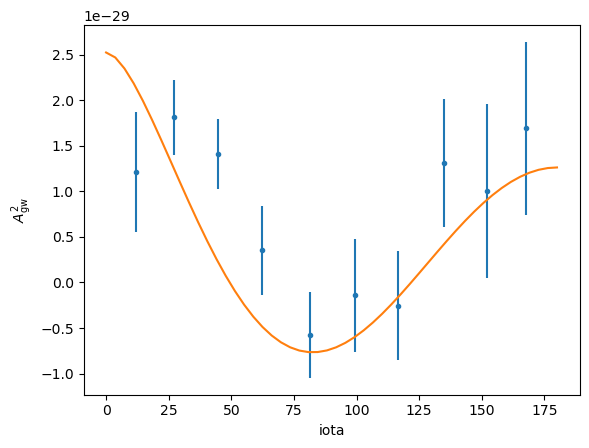

In [18]:
pp.errorbar(iotas, oses, yerr=osigs, fmt='.')

a = np.linspace(1e-6, 180)
hd = ost.os(p0)['os'] * ds.hd_orfa(np.cos(a * (np.pi/180.0)))

pp.plot(a, hd)
pp.xlabel('iota'); pp.ylabel(r'$A_\mathrm{gw}^2$');

Plot the distribution of SNRs on a subchain

In [19]:
chain = df.sample(1000).astype(np.float64)
p0s = {var: jnp.array(chain[var]) for var in df.columns}

In [20]:
vos = jax.jit(jax.vmap(os.os))

In [21]:
%time oses = vos(p0s)

CPU times: user 33.1 s, sys: 1.13 s, total: 34.2 s
Wall time: 34.1 s


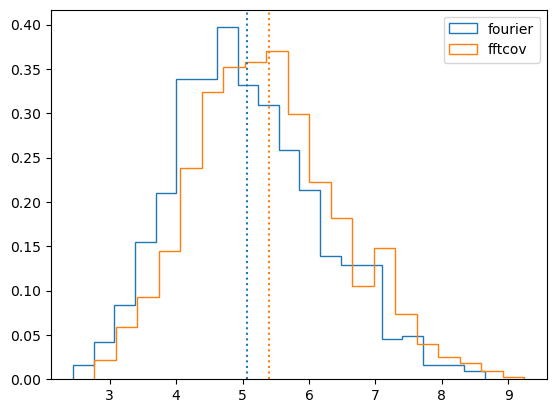

In [31]:
pp.hist(oses['snr'], histtype='step', bins=20, density=True, label='fourier');
# pp.hist(ostes['snr'], histtype='step', bins=20, density=True, label='fftcov');
pp.axvline(np.mean(oses['snr']), color='C0', ls=':');
# pp.axvline(np.mean(ostes['snr']), color='C1', ls=':');
pp.legend()

### Rapid simulation

Setting up for OS simulations:
* No residuals vector, but we include a delay that gets residuals from parameter `{psrname}_sim_y`.
* No fixed GPs.
* Limited timing-model variance.

In [8]:
Tspan = ds.getspan(psrs)

sim = ds.GlobalLikelihood([ds.PulsarLikelihood([ds.makedelay(psr, ds.getresiduals, name='sim'), 
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                # ds.makegp_ecorr(psr, psr.noisedict), # cannot do fixed GP at this time 
                                                ds.makegp_timing(psr, variance=1e-12, variable=True),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in psrs])

In [13]:
os = ds.OS(sim)

Get MAP noise parameters

In [9]:
df = pd.read_feather('../data/NG15yr-m2a-chain.feather')
p0 = df.iloc[df['logp'].argmax()].to_dict()

So this would be the real-data OS

In [15]:
os.os({**p0, **{f'{psr.name}_sim_y': psr.residuals for psr in psrs}})

{'os': Array(1.76175729e-29, dtype=float64),
 'os_sigma': Array(5.68442981e-29, dtype=float64),
 'snr': Array(0.30992683, dtype=float64),
 'log10_A': -14.186517715454102}

This direct-sample function takes a random normal vector with the number of degrees of freedom of the OS (which are available as `oss.cnt`) and computes the OS as $\frac{1}{2} x^T Q x$. Note it's frozen to a set of parameters.

In [109]:
oss = os.sample_rhosigma(p0)

In [110]:
oss(ds.jnpnormal(ds.rngkey(42), oss.cnt))

Array(-0.94545471, dtype=float64)

We make a JIT/vmap version to make a distribution.

In [111]:
voss = jax.jit(jax.vmap(oss))

In [112]:
n = 10000

In [113]:
%time snrs = voss(ds.matrix.jnpnormal(ds.rngkey(42), (n, oss.cnt))).block_until_ready()

CPU times: user 40.3 s, sys: 4.55 s, total: 44.8 s
Wall time: 4.37 s


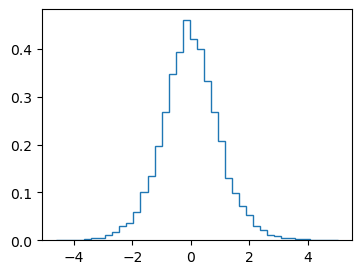

In [114]:
pp.figure(figsize=(4,3)); pp.hist(snrs, histtype='step', bins=40, density=True);